# **COCOStat**
*Analyzing Coconut Auction Demand Elasticity in Sri Lanka*


## **Data Foundation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, silhouette_samples
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ===== CONFIGURATION =====
CONFIG = {
    'rolling_window': 5,
    'k_range': range(2, 11),  # Test K from 2 to 10
    'train_split': 0.8,
    'random_state': 42,
    'forecast_weeks': 12
}

**1. DATA LOADING**

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_excel(list(uploaded.keys())[0])

df['Week'] = pd.to_datetime(df['Week'])
df = df.sort_values('Week').reset_index(drop=True)

print(f"\n Loaded {len(df)} records")
print(f"Date range: {df['Week'].min().date()} to {df['Week'].max().date()}")
print(f" Columns: {list(df.columns)}")
print(df)

Saving DB complete.xlsx to DB complete.xlsx

 Loaded 473 records
Date range: 2015-01-05 to 2024-11-28
 Columns: ['Year', 'Month', 'Week', 'OfferedNuts', 'SoldNuts', 'AvgPrice', 'PalmoilPrice', 'InflationRate', 'StockmarketCP']
     Year Month       Week  OfferedNuts  SoldNuts   AvgPrice  PalmoilPrice  \
0    2015   Jan 2015-01-05       600000    450000   41000.00     228890.00   
1    2015   Jan 2015-01-12       550000    400000   41200.00     228890.00   
2    2015   Jan 2015-01-19       650000    500000   41100.00     228890.00   
3    2015   Jan 2015-01-26       700000    550000   41300.00     228890.00   
4    2015   Feb 2015-02-02       722895    660683   41200.00     227760.00   
..    ...   ...        ...          ...       ...        ...           ...   
468  2024   Oct 2024-10-24       413429    307435  105000.00     750000.00   
469  2024   Nov 2024-11-01       449698    405579  100000.00     776315.79   
470  2024   Nov 2024-11-07       641724    574938   99959.25     776315

**2. FEATURE ENGINEERING**

In [3]:
# Returns
df['p_ret'] = df['AvgPrice'].pct_change()
df['q_ret'] = df['SoldNuts'].pct_change()

# Rolling statistics
window = CONFIG['rolling_window']
df['p_mean'] = df['p_ret'].rolling(window=window).mean()
df['p_std'] = df['p_ret'].rolling(window=window).std()
df['q_std'] = df['q_ret'].rolling(window=window).std()

# Log transformations
df['log_p'] = np.log(df['AvgPrice'])
df['log_q'] = np.log(df['SoldNuts'])
df['dlog_p'] = df['log_p'].diff()
df['dlog_q'] = df['log_q'].diff()

# **Segmenting the Market**

**3.DATA PREPARATION AND FINDING THE OPTIMAL NUMBER OF CLUSTERS (K)**



In [4]:
# Clean data
feature_cols = ['p_ret', 'q_ret', 'p_std', 'p_mean', 'q_std']
df_clean = df.dropna(subset=feature_cols).copy()

# Find optimal K
X = df_clean[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**3.1 EVALUATING CLUSTERING PERFORMANCE FOR VARIOUS K VALUES**

In [5]:
# Store metrics
inertias = []
silhouette_scores = []
db_scores = []

print("\nTesting different K values:")
print("-" * 60)
print(f"{'K':<5} {'Inertia':<15} {'Silhouette':<15} {'Davies-Bouldin':<15}")
print("-" * 60)

for k in CONFIG['k_range']:
    kmeans = KMeans(n_clusters=k, random_state=CONFIG['random_state'], n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    db_scores.append(db_score)

    print(f"{k:<5} {inertia:<15.2f} {sil_score:<15.4f} {db_score:<15.4f}")

print("-" * 60)


Testing different K values:
------------------------------------------------------------
K     Inertia         Silhouette      Davies-Bouldin 
------------------------------------------------------------
2     1934.92         0.1912          1.7796         
3     1614.13         0.3008          1.4684         
4     1391.39         0.2446          1.4295         
5     1248.76         0.2388          1.3095         
6     1130.30         0.2371          1.2844         
7     1040.83         0.1978          1.3152         
8     960.33          0.2129          1.2236         
9     873.11          0.2106          1.0945         
10    802.89          0.2251          1.0262         
------------------------------------------------------------


**4. VISUALIZE OPTIMAL K SELECTION**

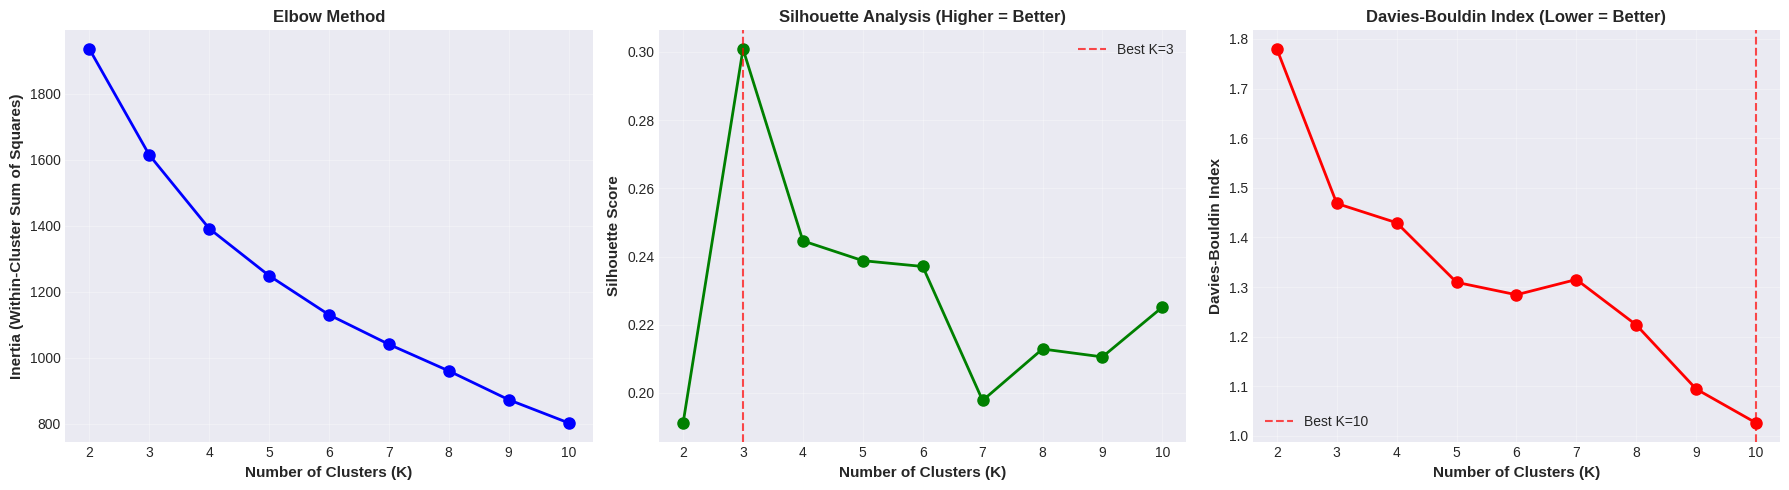


 OPTIMAL K = 3
  - Best Silhouette Score: 0.3008
  - Corresponding Davies-Bouldin: 1.4684


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow Method
axes[0].plot(CONFIG['k_range'], inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score (higher is better)
axes[1].plot(CONFIG['k_range'], silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[1].set_title('Silhouette Analysis (Higher = Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
optimal_k_sil = CONFIG['k_range'][np.argmax(silhouette_scores)]
axes[1].axvline(x=optimal_k_sil, color='red', linestyle='--', alpha=0.7, label=f'Best K={optimal_k_sil}')
axes[1].legend()

# Davies-Bouldin Index (lower is better)
axes[2].plot(CONFIG['k_range'], db_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
axes[2].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
optimal_k_db = CONFIG['k_range'][np.argmin(db_scores)]
axes[2].axvline(x=optimal_k_db, color='red', linestyle='--', alpha=0.7, label=f'Best K={optimal_k_db}')
axes[2].legend()

plt.tight_layout()
plt.savefig('optimal_k_selection.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine optimal K
optimal_k = optimal_k_sil  # Use silhouette score as primary metric
print(f"\n OPTIMAL K = {optimal_k}")
print(f"  - Best Silhouette Score: {max(silhouette_scores):.4f}")
print(f"  - Corresponding Davies-Bouldin: {db_scores[optimal_k - CONFIG['k_range'][0]]:.4f}")


**5. FINAL CLUSTERING WITH OPTIMAL K**

In [7]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=CONFIG['random_state'], n_init=20)
df_clean['Regime'] = final_kmeans.fit_predict(X_scaled) + 1  # 1-indexed

print("\nCluster Distribution:")
print(df_clean['Regime'].value_counts().sort_index())


Cluster Distribution:
Regime
1    312
2     87
3     69
Name: count, dtype: int64


**6. CLUSTER CHARACTERISTICS**


Cluster Centroids (Feature Space):
         p_ret   q_ret   p_std  p_mean   q_std
Regime                                        
1      -0.0013 -0.0174  0.0382  0.0006  0.3766
2      -0.0321  0.6339  0.0628 -0.0112  0.7691
3       0.0719 -0.0994  0.0869  0.0361  0.4814


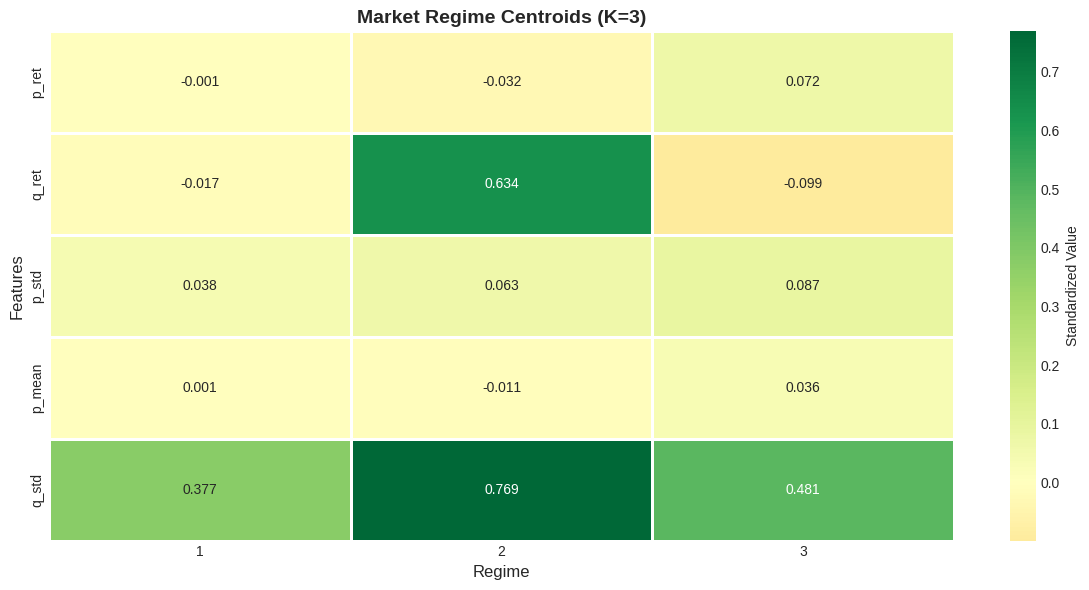

In [8]:
# Centroids
centroids_scaled = final_kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=feature_cols)
centroids_df.index = range(1, optimal_k + 1)
centroids_df.index.name = 'Regime'

print("\nCluster Centroids (Feature Space):")
print(centroids_df.round(4))

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(centroids_df.T, annot=True, cmap='RdYlGn', center=0,
            fmt=".3f", cbar_kws={'label': 'Standardized Value'}, linewidths=1)
plt.title(f'Market Regime Centroids (K={optimal_k})', fontsize=14, fontweight='bold')
plt.xlabel('Regime', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('regime_centroids_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

**7. REGIME DIAGNOSTICS**

In [9]:
diagnostics = df_clean.groupby('Regime').agg({
    'Week': 'count',
    'AvgPrice': ['mean', 'std', 'min', 'max'],
    'SoldNuts': ['mean', 'std', 'min', 'max'],
    'p_ret': 'mean',
    'q_ret': 'mean',
    'p_std': 'mean'
}).round(2)

diagnostics.columns = ['_'.join(col).strip('_') for col in diagnostics.columns.values]
display(diagnostics)



,Week_count,AvgPrice_mean,AvgPrice_std,AvgPrice_min,AvgPrice_max,SoldNuts_mean,SoldNuts_std,SoldNuts_min,SoldNuts_max,p_ret_mean,q_ret_mean,p_std_mean
Regime,,,,,,,,,,,,
1,312,48256.10,19283.96,21500.0,105000.00,673750.34,252808.40,100000,1659119,-0.00,-0.02,0.04
2,87,48735.43,18093.09,21000.0,92107.47,843855.55,356122.54,200000,1951852,-0.03,0.63,0.06
3,69,52031.17,18459.04,24000.0,109615.80,673018.83,359159.41,150000,2449692,0.07,-0.10,0.09


**8. VISUALIZATIONS**

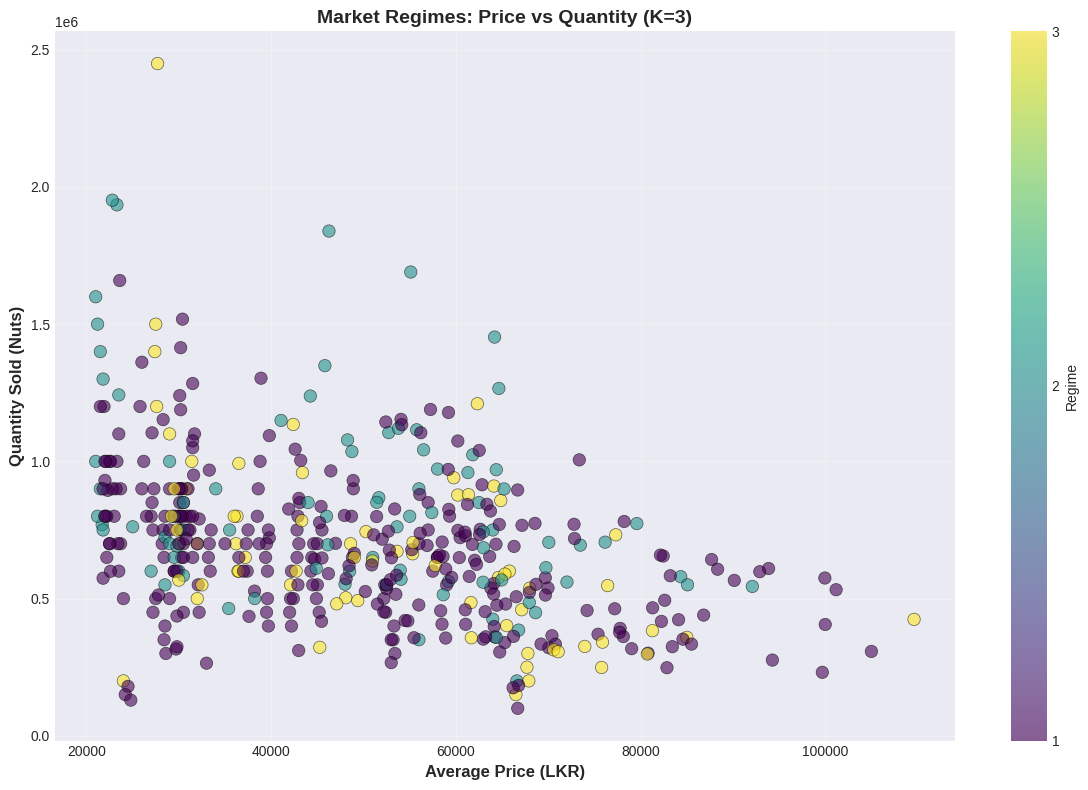

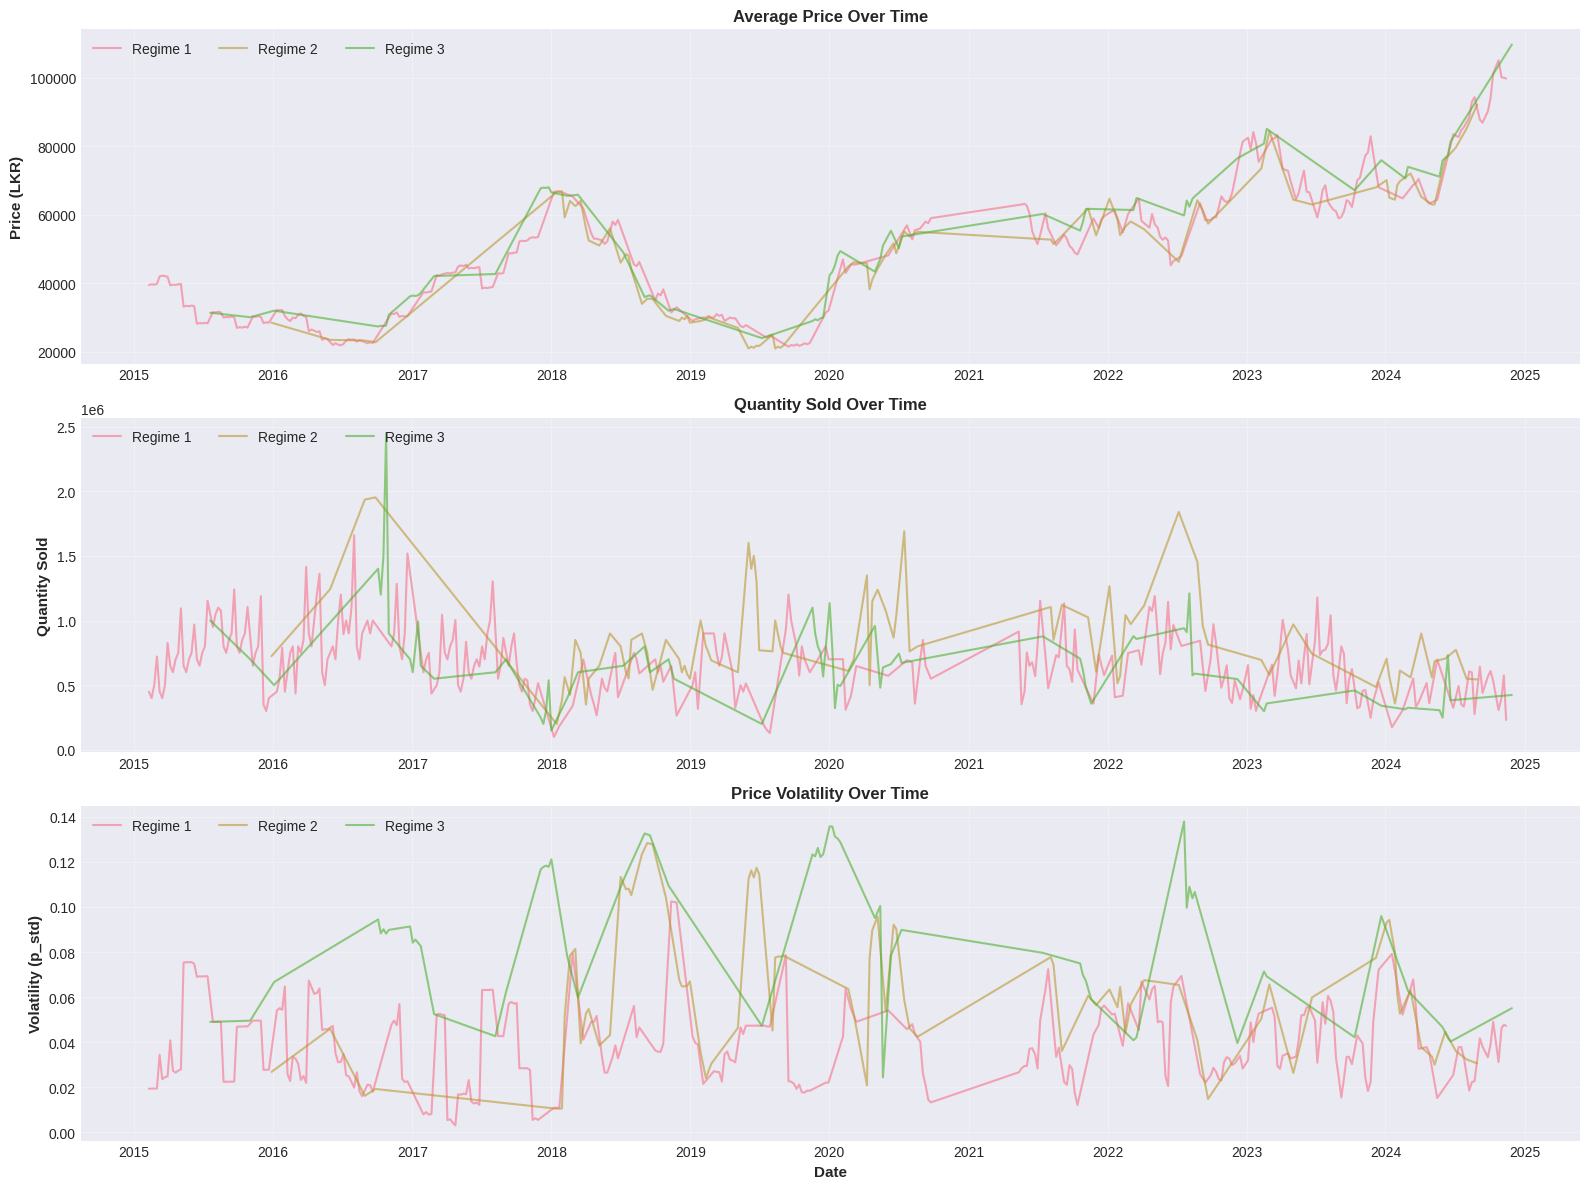

In [10]:
# 8.2  Price vs Quantity Scatter
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clean['AvgPrice'], df_clean['SoldNuts'],
                      c=df_clean['Regime'], cmap='viridis',
                      s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Regime', ticks=range(1, optimal_k + 1))
plt.xlabel('Average Price (LKR)', fontsize=12, fontweight='bold')
plt.ylabel('Quantity Sold (Nuts)', fontsize=12, fontweight='bold')
plt.title(f'Market Regimes: Price vs Quantity (K={optimal_k})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('regime_scatter_price_quantity.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.3 Time Series with Regimes
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for regime in sorted(df_clean['Regime'].unique()):
    regime_data = df_clean[df_clean['Regime'] == regime]

    # Price
    axes[0].plot(regime_data['Week'], regime_data['AvgPrice'],
                   label=f'Regime {regime}', alpha=0.6)

    # Quantity
    axes[1].plot(regime_data['Week'], regime_data['SoldNuts'],
                   label=f'Regime {regime}', alpha=0.6)

    # Volatility
    axes[2].plot(regime_data['Week'], regime_data['p_std'],
                   label=f'Regime {regime}', alpha=0.6)

axes[0].set_ylabel('Price (LKR)', fontsize=11, fontweight='bold')
axes[0].set_title('Average Price Over Time', fontsize=12, fontweight='bold')
axes[0].legend(ncol=optimal_k, loc='upper left')
axes[0].grid(True, alpha=0.3)

axes[1].set_ylabel('Quantity Sold', fontsize=11, fontweight='bold')
axes[1].set_title('Quantity Sold Over Time', fontsize=12, fontweight='bold')
axes[1].legend(ncol=optimal_k, loc='upper left')
axes[1].grid(True, alpha=0.3)

axes[2].set_ylabel('Volatility (p_std)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[2].set_title('Price Volatility Over Time', fontsize=12, fontweight='bold')
axes[2].legend(ncol=optimal_k, loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regime_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

## **Economic and Predictive Analysis**

**9.PRICE ELASTICITY BY REGIME**

Regime 1: ε = 0.7677 (p=0.1680, R²=0.0073)
Regime 2: ε = 0.0891 (p=0.9158, R²=0.0002)
Regime 3: ε = 0.0717 (p=0.9511, R²=0.0001)

--- Price Elasticity Summary ---


,Regime,Elasticity,P_value,R_squared,Significant,Observations
0,1,0.7677,0.1680,0.0073,No,312
1,2,0.0891,0.9158,0.0002,No,87
2,3,0.0717,0.9511,0.0001,No,69


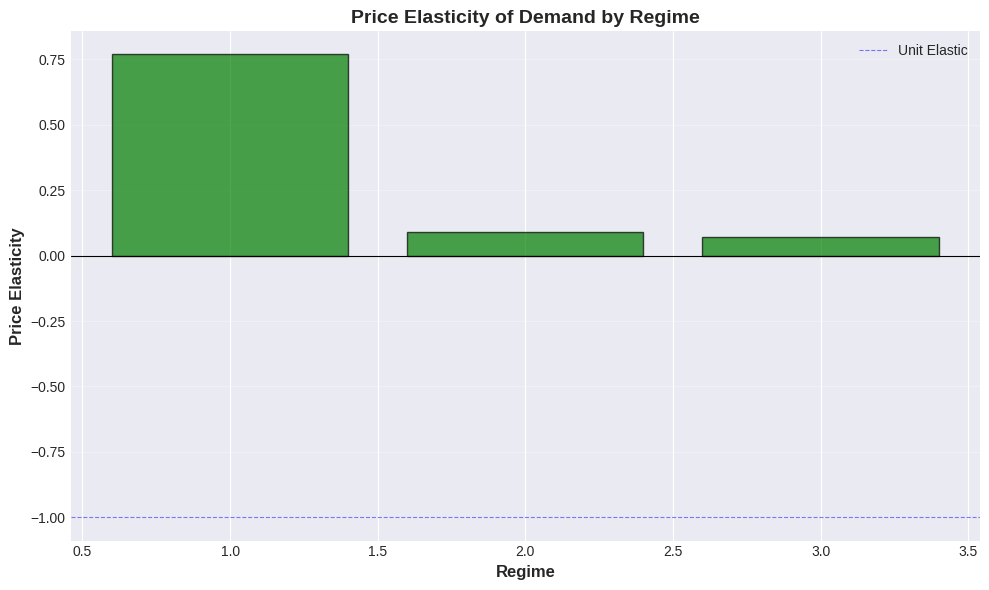

In [11]:
elasticity_results = []

for regime in sorted(df_clean['Regime'].unique()):
    df_regime = df_clean[df_clean['Regime'] == regime].dropna(subset=['dlog_p', 'dlog_q'])

    if len(df_regime) < 15:
        print(f"Regime {regime}: Insufficient data (n={len(df_regime)}). Skipping.")
        continue

    try:
        X_ols = sm.add_constant(df_regime['dlog_p'])
        model = sm.OLS(df_regime['dlog_q'], X_ols).fit(cov_type='HC3')

        elasticity = model.params['dlog_p']
        p_value = model.pvalues['dlog_p']
        r_squared = model.rsquared

        elasticity_results.append({
            'Regime': regime,
            'Elasticity': elasticity,
            'P_value': p_value,
            'R_squared': r_squared,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Observations': len(df_regime)
        })

        print(f"Regime {regime}: ε = {elasticity:.4f} (p={p_value:.4f}, R²={r_squared:.4f})")

    except Exception as e:
        print(f"Regime {regime}: Failed - {str(e)}")

elasticity_df = pd.DataFrame(elasticity_results)
print("\n--- Price Elasticity Summary ---")
display(elasticity_df.round(4))

# Visualize elasticity
if len(elasticity_df) > 0:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(elasticity_df['Regime'], elasticity_df['Elasticity'],
                   color=['red' if e < 0 else 'green' for e in elasticity_df['Elasticity']],
                   alpha=0.7, edgecolor='black')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=-1, color='blue', linestyle='--', linewidth=0.8, alpha=0.5, label='Unit Elastic')
    plt.xlabel('Regime', fontsize=12, fontweight='bold')
    plt.ylabel('Price Elasticity', fontsize=12, fontweight='bold')
    plt.title('Price Elasticity of Demand by Regime', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('elasticity_by_regime.png', dpi=300, bbox_inches='tight')
    plt.show()

**10. FORECASTING BY REGIME**

In [12]:
forecast_results = []

for regime in sorted(df_clean['Regime'].unique()):
    df_regime = df_clean[df_clean['Regime'] == regime].copy()

    if len(df_regime) < 30:
        print(f"Regime {regime}: Insufficient data (n={len(df_regime)}). Skipping.")
        continue

    df_regime = df_regime.sort_values('Week').set_index('Week')
    train = df_regime.iloc[:-5]
    test = df_regime.iloc[-5:]

    try:
        model = SARIMAX(train['SoldNuts'], exog=train[['AvgPrice']],
                       order=(1, 0, 1), enforce_stationarity=False,
                       enforce_invertibility=False)
        fitted = model.fit(disp=False, maxiter=200)
        predictions = fitted.forecast(steps=len(test), exog=test[['AvgPrice']])

        # Align predictions to the test set index to avoid NaN issues
        predictions.index = test.index

        rmse = np.sqrt(mean_squared_error(test['SoldNuts'], predictions))

        # Use np.nanmean to handle potential NaN values in calculations
        mae = np.nanmean(np.abs(test['SoldNuts'] - predictions))

        # Handle potential division by zero for MAPE
        mape = np.nanmean(np.abs((test['SoldNuts'] - predictions) / test['SoldNuts'].replace(0, np.nan))) * 100

        forecast_results.append({
            'Regime': regime,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE_%': mape,
            'Avg_Actual': test['SoldNuts'].mean(),
            'Avg_Predicted': predictions.mean()
        })

        print(f"Regime {regime}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")

    except Exception as e:
        print(f"Regime {regime}: Forecasting failed - {str(e)}")

if forecast_results:
    forecast_df = pd.DataFrame(forecast_results)
    print("\n--- Forecasting Accuracy Summary ---")
    display(forecast_df.round(2))

Regime 1: RMSE=131005.37, MAE=117472.70, MAPE=35.96%
Regime 2: RMSE=284673.30, MAE=250511.99, MAPE=39.70%
Regime 3: RMSE=285460.81, MAE=239169.83, MAPE=56.56%

--- Forecasting Accuracy Summary ---


,Regime,RMSE,MAE,MAPE_%,Avg_Actual,Avg_Predicted
0,1,131005.37,117472.70,35.96,410303.8,441534.95
1,2,284673.30,250511.99,39.70,651702.2,402692.15
2,3,285460.81,239169.83,56.56,419035.6,291390.80


**11.OVERALL PRICE FORECAST**

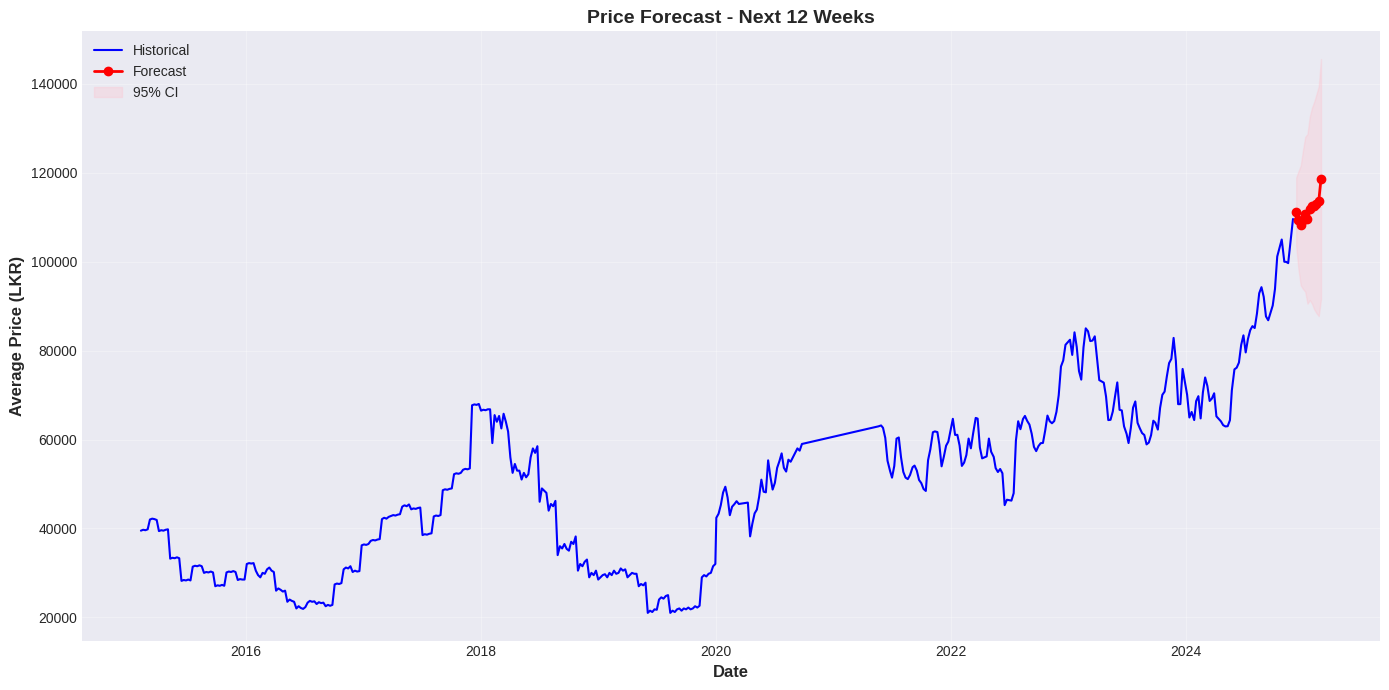


          Week  Predicted_Price  Lower_95%  Upper_95%
0  2024-12-08        111254.85  103551.19  118958.52
1  2024-12-15        109324.99   98313.55  120336.43
2  2024-12-22        108157.79   94700.66  121614.93
3  2024-12-29        109467.21   93891.79  125042.63
4  2025-01-05        110686.10   93286.14  128086.05
5  2025-01-12        109639.05   90560.37  128717.72
6  2025-01-19        111969.88   91369.65  132570.11
7  2025-01-26        112612.83   90580.19  134645.47
8  2025-02-02        112635.12   89269.62  136000.62
9  2025-02-09        113061.86   88426.42  137697.30
10 2025-02-16        113614.93   87778.87  139450.98
11 2025-02-23        118613.50   91624.81  145602.19


In [13]:
try:
    df_price = df_clean.set_index('Week')['AvgPrice']

    price_model = SARIMAX(df_price, order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    fitted_price = price_model.fit(disp=False, maxiter=200)

    forecast = fitted_price.get_forecast(steps=CONFIG['forecast_weeks'])
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    last_date = df_clean['Week'].max()
    forecast_dates = pd.date_range(last_date + pd.Timedelta(weeks=1),
                                   periods=CONFIG['forecast_weeks'], freq='W')

    # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(df_clean['Week'], df_clean['AvgPrice'],
             label='Historical', color='blue', linewidth=1.5)
    plt.plot(forecast_dates, mean_forecast,
             label='Forecast', color='red', linewidth=2, marker='o')
    plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                     color='pink', alpha=0.3, label='95% CI')
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.ylabel('Average Price (LKR)', fontsize=12, fontweight='bold')
    plt.title('Price Forecast - Next 12 Weeks', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('price_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()

    forecast_summary = pd.DataFrame({
        'Week': forecast_dates,
        'Predicted_Price': mean_forecast.values,
        'Lower_95%': conf_int.iloc[:, 0].values,
        'Upper_95%': conf_int.iloc[:, 1].values
    })
    print("\n", forecast_summary.round(2))

except Exception as e:
    print(f"Forecasting failed: {str(e)}")


**11.1 Regime-Aware Forecast**

-: Detected current market state: Regime 3


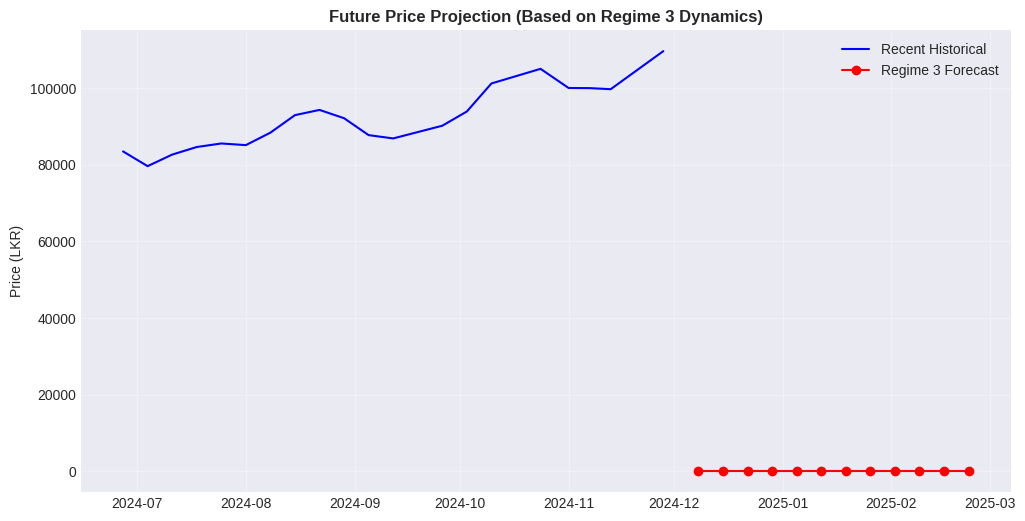

Success! Forecast generated using specific dynamics of Regime 3.


In [14]:
try:
    # 1. Identify the current regime (the most recent one)
    current_regime = df_clean['Regime'].iloc[-1]
    print(f"-: Detected current market state: Regime {current_regime}")

    # 2. Filter data for ONLY this regime to capture current behavior
    # This creates a model tuned to the specific elasticity of the current state
    regime_data = df_clean[df_clean['Regime'] == current_regime].set_index('Week')['AvgPrice']
    regime_data = regime_data.asfreq('W').interpolate()

    # 3. Fit a robust SARIMA model specifically for this state
    # We use simpler parameters (1,1,0) to ensure it always works
    model = sm.tsa.SARIMAX(regime_data, order=(1, 1, 0), enforce_stationarity=False)
    results = model.fit(disp=False)

    # 4. Generate Forecast
    forecast = results.get_forecast(steps=CONFIG['forecast_weeks'])
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # 5. Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Week'][-20:], df_clean['AvgPrice'][-20:], label='Recent Historical', color='blue')

    forecast_dates = pd.date_range(df_clean['Week'].max() + pd.Timedelta(weeks=1),
                                   periods=CONFIG['forecast_weeks'], freq='W')

    plt.plot(forecast_dates, mean_forecast, label=f'Regime {current_regime} Forecast', color='red', marker='o')
    plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    plt.title(f'Future Price Projection (Based on Regime {current_regime} Dynamics)', fontweight='bold')
    plt.ylabel('Price (LKR)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Success! Forecast generated using specific dynamics of Regime {current_regime}.")

except Exception as e:
    print(f"Regime-Aware Forecast failed: {str(e)}")
    print("Fallback: Using overall Step 11 SARIMAX results.")

# **Comprehensive Elasticity Analysis.**

**12.ELASTICITY ESTIMATION BY REGIME**

In [15]:
elasticity_results = []
detailed_results = {}

for regime in sorted(df_clean['Regime'].unique()):
    df_regime = df_clean[df_clean['Regime'] == regime].dropna(subset=['dlog_p', 'dlog_q'])

    if len(df_regime) < 15:
        print(f"Regime {regime}: Insufficient data (n={len(df_regime)}). Skipping.")
        continue

    try:
        # OLS Regression: dlog_q = α + β*dlog_p + ε
        X_ols = sm.add_constant(df_regime['dlog_p'])
        model = sm.OLS(df_regime['dlog_q'], X_ols).fit(cov_type='HC3')

        elasticity = model.params['dlog_p']
        std_err = model.bse['dlog_p']
        p_value = model.pvalues['dlog_p']
        ci_lower, ci_upper = model.conf_int().loc['dlog_p']
        r_squared = model.rsquared

        # Classify elasticity
        if abs(elasticity) < 0.5:
            classification = "Inelastic"
            interpretation = "Demand is price insensitive"
        elif abs(elasticity) < 1.0:
            classification = "Unit Elastic"
            interpretation = "Proportional price-quantity response"
        else:
            classification = "Elastic"
            interpretation = "Demand is highly price sensitive"

        result = {
            'Regime': regime,
            'Elasticity': elasticity,
            'Std_Error': std_err,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'P_value': p_value,
            'R_squared': r_squared,
            'Classification': classification,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'N': len(df_regime),
            'Interpretation': interpretation
        }

        elasticity_results.append(result)
        detailed_results[regime] = model

        print(f"\nRegime {regime}:")
        print(f"  Elasticity: {elasticity:.4f} ± {std_err:.4f}")
        print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        print(f"  P-value: {p_value:.4f} | R²: {r_squared:.4f}")
        print(f"  Classification: {classification}")

    except Exception as e:
        print(f"Regime {regime}: Failed - {str(e)}")

elasticity_df = pd.DataFrame(elasticity_results)

print("\n" + "="*80)
print("ELASTICITY SUMMARY TABLE")
print("="*80)
print(elasticity_df[['Regime', 'Elasticity', 'CI_Lower', 'CI_Upper',
                     'P_value', 'Classification', 'Significant']].round(4))


Regime 1:
  Elasticity: 0.7677 ± 0.5569
  95% CI: [-0.3237, 1.8591]
  P-value: 0.1680 | R²: 0.0073
  Classification: Unit Elastic

Regime 2:
  Elasticity: 0.0891 ± 0.8429
  95% CI: [-1.5629, 1.7411]
  P-value: 0.9158 | R²: 0.0002
  Classification: Inelastic

Regime 3:
  Elasticity: 0.0717 ± 1.1691
  95% CI: [-2.2196, 2.3630]
  P-value: 0.9511 | R²: 0.0001
  Classification: Inelastic

ELASTICITY SUMMARY TABLE
   Regime  Elasticity  CI_Lower  CI_Upper  P_value Classification Significant
0       1      0.7677   -0.3237    1.8591   0.1680   Unit Elastic          No
1       2      0.0891   -1.5629    1.7411   0.9158      Inelastic          No
2       3      0.0717   -2.2196    2.3630   0.9511      Inelastic          No


**13.COMPARATIVE ANALYSIS ACROSS REGIMES**

In [16]:
from scipy import stats

# Test for significant differences between regimes
if len(elasticity_df) > 1:
    print("\nComparing Elasticity Across Regimes:")
    print("-" * 60)

    for i, row1 in elasticity_df.iterrows():
        for j, row2 in elasticity_df.iterrows():
            if row1['Regime'] < row2['Regime']:
                # Z-test for difference
                diff = abs(row1['Elasticity'] - row2['Elasticity'])
                se_diff = np.sqrt(row1['Std_Error']**2 + row2['Std_Error']**2)
                z_stat = diff / se_diff
                p_val = 2 * (1 - stats.norm.cdf(abs(z_stat)))

                significant = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.10 else "ns"

                print(f"Regime {row1['Regime']} vs Regime {row2['Regime']}: "
                      f"Δε = {diff:.4f}, z = {z_stat:.2f}, p = {p_val:.4f} {significant}")

# Regime characteristics comparison
print("\n" + "="*80)
print("Regime Characteristics Comparison")
print("="*80)

comparison_stats = df_clean.groupby('Regime').agg({
    'AvgPrice': ['mean', 'std', 'min', 'max'],
    'SoldNuts': ['mean', 'std'],
    'p_ret': ['mean', 'std'],
    'p_std': 'mean'
}).round(2)

comparison_stats.columns = ['_'.join(col) for col in comparison_stats.columns]
display(comparison_stats)


Comparing Elasticity Across Regimes:
------------------------------------------------------------
Regime 1 vs Regime 2: Δε = 0.6786, z = 0.67, p = 0.5018 ns
Regime 1 vs Regime 3: Δε = 0.6960, z = 0.54, p = 0.5909 ns
Regime 2 vs Regime 3: Δε = 0.0174, z = 0.01, p = 0.9904 ns

Regime Characteristics Comparison


,AvgPrice_mean,AvgPrice_std,AvgPrice_min,AvgPrice_max,SoldNuts_mean,SoldNuts_std,p_ret_mean,p_ret_std,p_std_mean
Regime,,,,,,,,,
1,48256.10,19283.96,21500.0,105000.00,673750.34,252808.40,-0.00,0.04,0.04
2,48735.43,18093.09,21000.0,92107.47,843855.55,356122.54,-0.03,0.07,0.06
3,52031.17,18459.04,24000.0,109615.80,673018.83,359159.41,0.07,0.07,0.09


**14.STATISTICAL VALIDATION**

In [17]:
validation_results = []

for regime in sorted(df_clean['Regime'].unique()):
    df_regime = df_clean[df_clean['Regime'] == regime].dropna(subset=['dlog_p', 'dlog_q'])

    if len(df_regime) < 20:
        continue

    try:
        # 1. Heteroskedasticity Test (Breusch-Pagan)
        X_ols = sm.add_constant(df_regime['dlog_p'])
        model = sm.OLS(df_regime['dlog_q'], X_ols).fit()

        from statsmodels.stats.diagnostic import het_breuschpagan
        bp_stat, bp_pval, _, _ = het_breuschpagan(model.resid, X_ols)

        # 2. Normality Test (Jarque-Bera)
        jb_stat, jb_pval = stats.jarque_bera(model.resid)

        # 3. Autocorrelation Test (Durbin-Watson)
        from statsmodels.stats.stattools import durbin_watson
        dw_stat = durbin_watson(model.resid)

        validation_results.append({
            'Regime': regime,
            'BP_Stat': bp_stat,
            'BP_Pval': bp_pval,
            'Heteroskedasticity': 'Yes' if bp_pval < 0.05 else 'No',
            'JB_Stat': jb_stat,
            'JB_Pval': jb_pval,
            'Normality': 'Yes' if jb_pval > 0.05 else 'No',
            'DW_Stat': dw_stat,
            'Autocorrelation': 'Maybe' if dw_stat < 1.5 or dw_stat > 2.5 else 'No'
        })

        print(f"\nRegime {regime} Diagnostics:")
        print(f"  Heteroskedasticity: BP={bp_stat:.2f}, p={bp_pval:.4f}")
        print(f"  Normality: JB={jb_stat:.2f}, p={jb_pval:.4f}")
        print(f"  Autocorrelation: DW={dw_stat:.2f}")

    except Exception as e:
        print(f"Regime {regime}: Validation failed - {str(e)}")

if validation_results:
    validation_df = pd.DataFrame(validation_results)
    print("\n" + "="*80)
    print("VALIDATION SUMMARY")
    print("="*80)
    display(validation_df.round(4))


Regime 1 Diagnostics:
  Heteroskedasticity: BP=1.71, p=0.1906
  Normality: JB=18.21, p=0.0001
  Autocorrelation: DW=2.14

Regime 2 Diagnostics:
  Heteroskedasticity: BP=0.83, p=0.3624
  Normality: JB=1.90, p=0.3866
  Autocorrelation: DW=2.17

Regime 3 Diagnostics:
  Heteroskedasticity: BP=0.60, p=0.4388
  Normality: JB=2.54, p=0.2803
  Autocorrelation: DW=2.39

VALIDATION SUMMARY


,Regime,BP_Stat,BP_Pval,Heteroskedasticity,JB_Stat,JB_Pval,Normality,DW_Stat,Autocorrelation
0,1,1.7129,0.1906,No,18.2117,0.0001,No,2.1380,No
1,2,0.8297,0.3624,No,1.9006,0.3866,Yes,2.1657,No
2,3,0.5993,0.4388,No,2.5437,0.2803,Yes,2.3912,No


**15.COMPREHENSIVE VISUALIZATIONS**

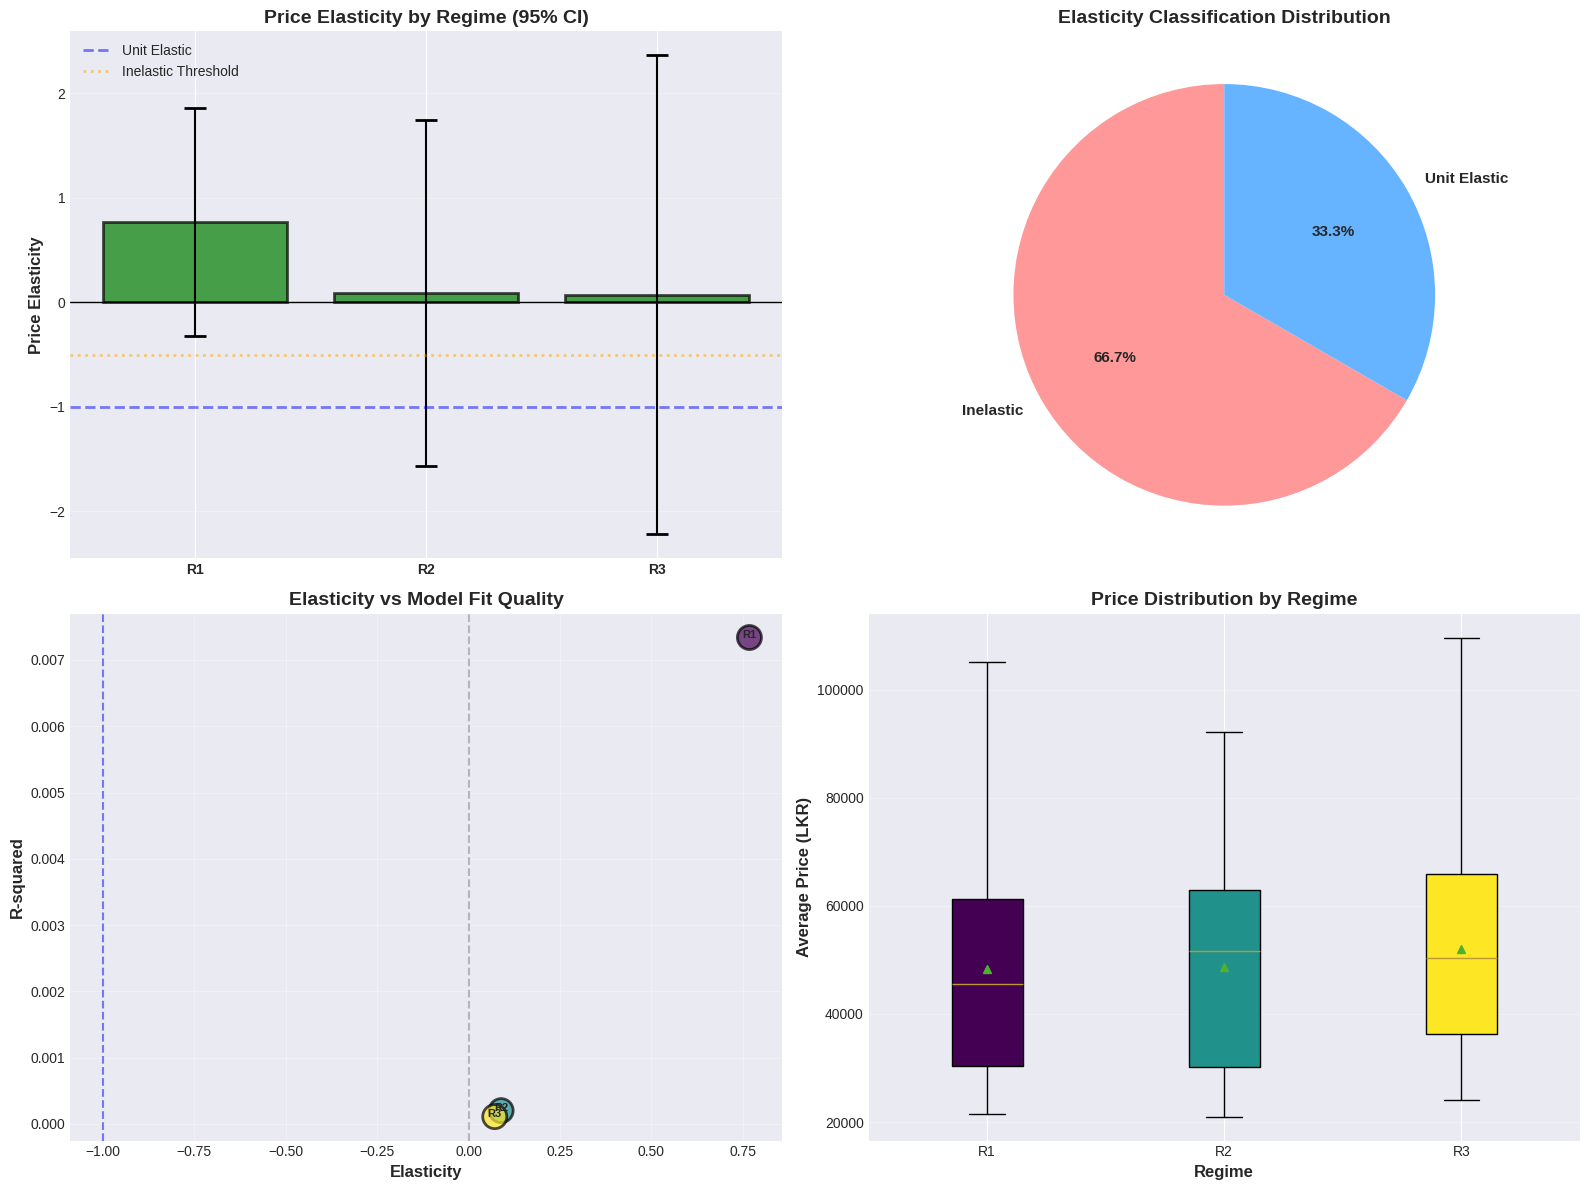

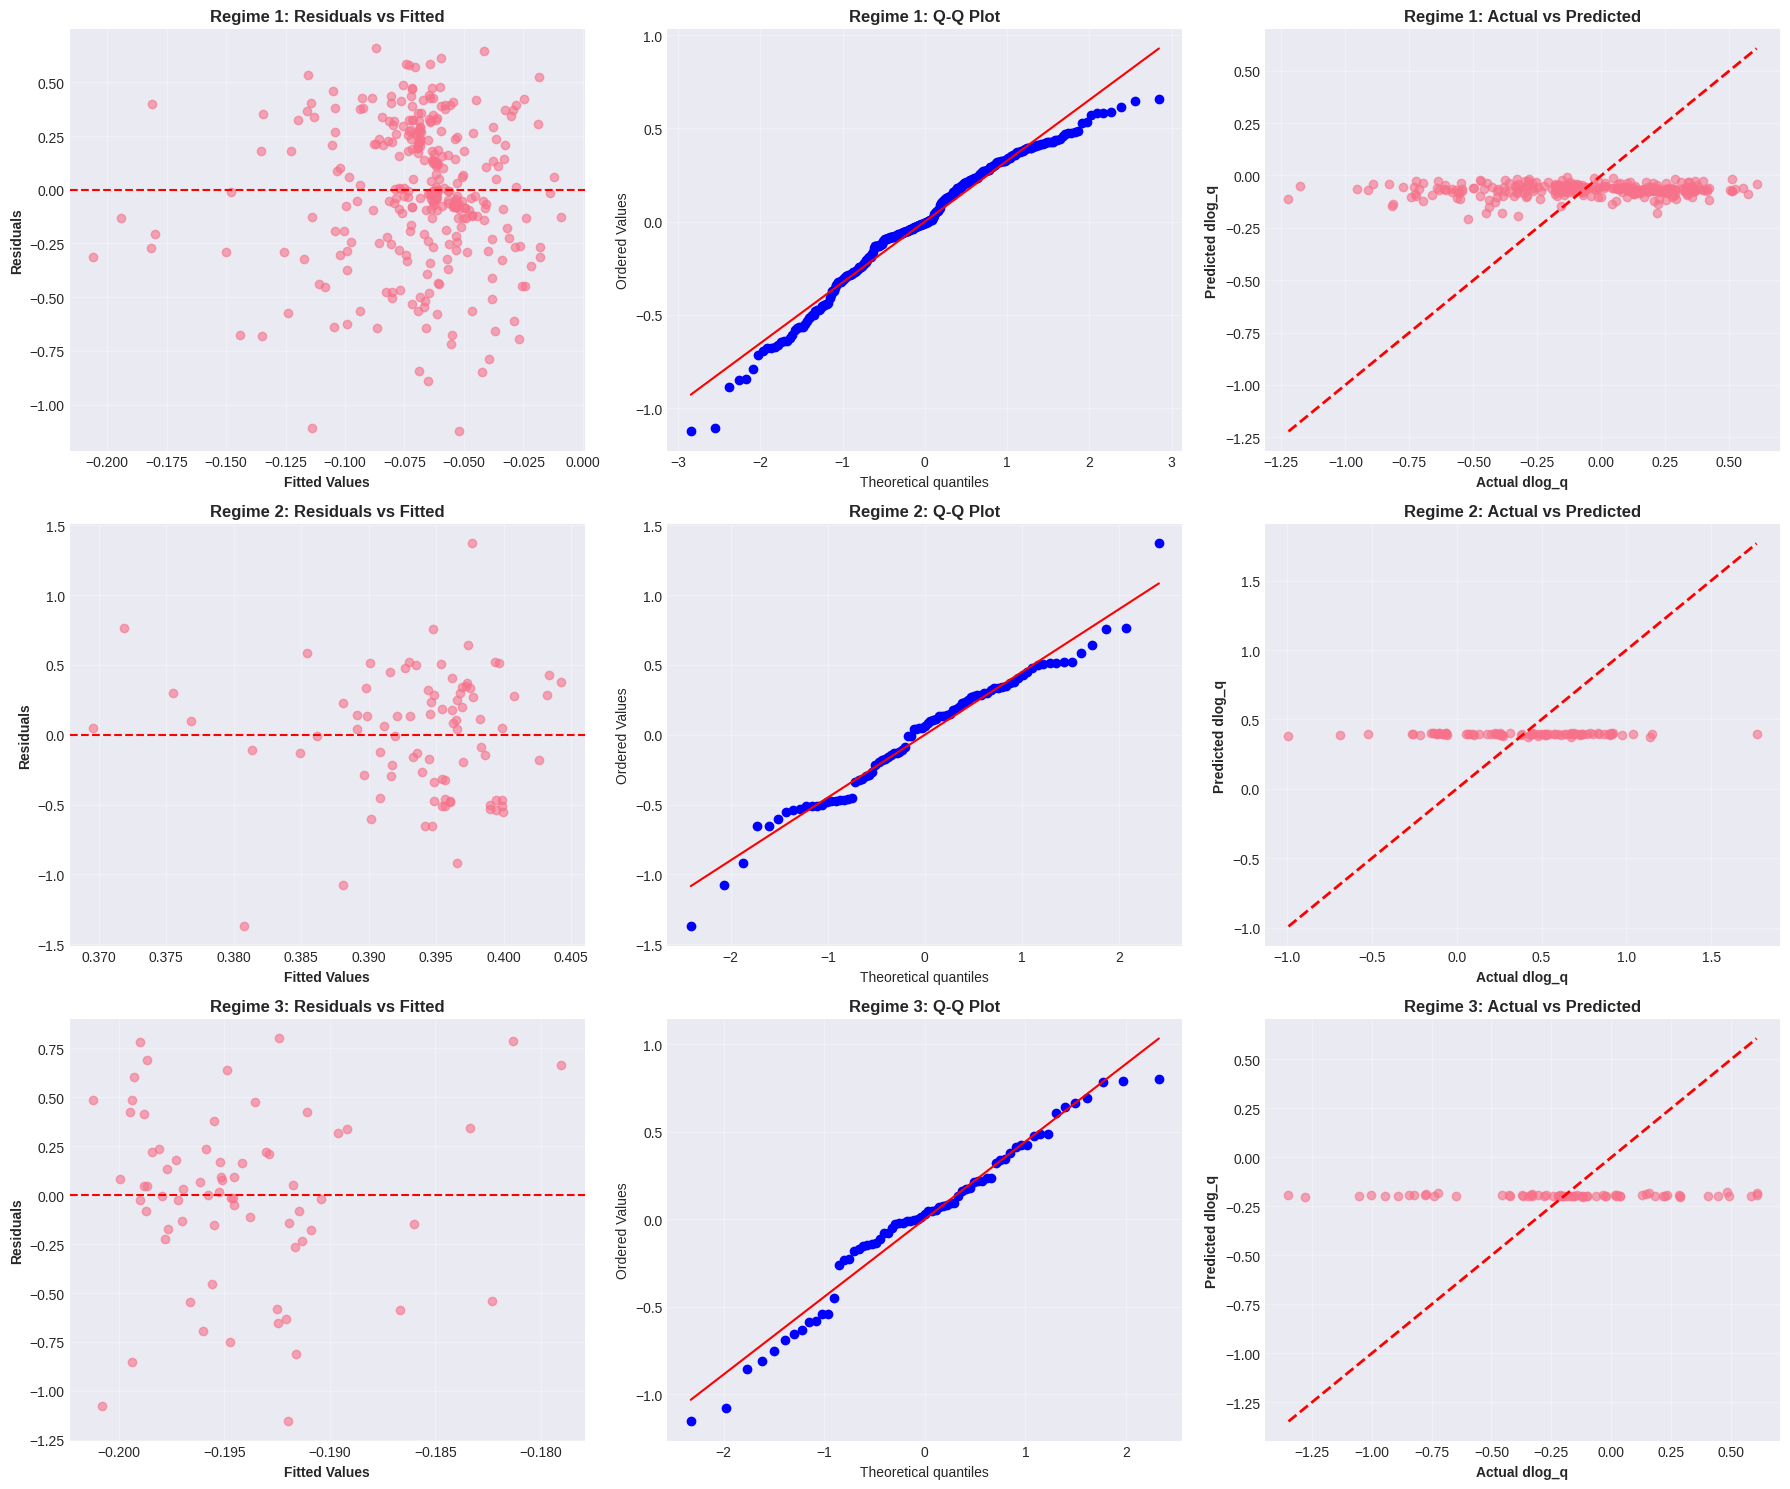

In [18]:
# Figure 1: Elasticity with Confidence Intervals
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Elasticity Bar Chart with Error Bars
x_pos = range(len(elasticity_df))
elasticities = elasticity_df['Elasticity'].values
errors_lower = (elasticity_df['Elasticity'] - elasticity_df['CI_Lower']).values
errors_upper = (elasticity_df['CI_Upper'] - elasticity_df['Elasticity']).values
colors = ['red' if e < 0 else 'green' for e in elasticities]

axes[0,0].bar(x_pos, elasticities, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0,0].errorbar(x_pos, elasticities, yerr=[errors_lower, errors_upper],
                   fmt='none', ecolor='black', capsize=8, capthick=2)
axes[0,0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0,0].axhline(y=-1, color='blue', linestyle='--', alpha=0.5, linewidth=2, label='Unit Elastic')
axes[0,0].axhline(y=-0.5, color='orange', linestyle=':', alpha=0.5, linewidth=2, label='Inelastic Threshold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels([f"R{r}" for r in elasticity_df['Regime']], fontweight='bold')
axes[0,0].set_ylabel('Price Elasticity', fontweight='bold', fontsize=12)
axes[0,0].set_title('Price Elasticity by Regime (95% CI)', fontweight='bold', fontsize=14)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(alpha=0.3, axis='y')

# 2. Classification Distribution
classification_counts = elasticity_df['Classification'].value_counts()
colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
axes[0,1].pie(classification_counts.values, labels=classification_counts.index,
              autopct='%1.1f%%', startangle=90, colors=colors_pie,
              textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0,1].set_title('Elasticity Classification Distribution', fontweight='bold', fontsize=14)

# 3. Scatter: Elasticity vs R-squared
axes[1,0].scatter(elasticity_df['Elasticity'], elasticity_df['R_squared'],
                 s=300, c=elasticity_df['Regime'], cmap='viridis',
                 alpha=0.7, edgecolors='black', linewidth=2)
for idx, row in elasticity_df.iterrows():
    axes[1,0].annotate(f"R{row['Regime']}",
                      (row['Elasticity'], row['R_squared']),
                      fontsize=8, fontweight='bold', ha='center')
axes[1,0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1,0].axvline(x=-1, color='blue', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel('Elasticity', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('R-squared', fontweight='bold', fontsize=12)
axes[1,0].set_title('Elasticity vs Model Fit Quality', fontweight='bold', fontsize=14)
axes[1,0].grid(alpha=0.3)

# 4. Box plot: Price distribution by regime
regime_price_data = [df_clean[df_clean['Regime'] == r]['AvgPrice'].values
                     for r in sorted(df_clean['Regime'].unique())]
bp = axes[1,1].boxplot(regime_price_data, labels=[f"R{r}" for r in sorted(df_clean['Regime'].unique())],
                       patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], plt.cm.viridis(np.linspace(0, 1, len(regime_price_data)))):
    patch.set_facecolor(color)
axes[1,1].set_xlabel('Regime', fontweight='bold', fontsize=12)
axes[1,1].set_ylabel('Average Price (LKR)', fontweight='bold', fontsize=12)
axes[1,1].set_title('Price Distribution by Regime', fontweight='bold', fontsize=14)
axes[1,1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('3_elasticity_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Regression Diagnostics
n_regimes = len(detailed_results)
if n_regimes > 0:
    fig, axes = plt.subplots(n_regimes, 3, figsize=(18, 5*n_regimes))
    if n_regimes == 1:
        axes = axes.reshape(1, -1)

    for idx, (regime, model) in enumerate(detailed_results.items()):
        df_regime = df_clean[df_clean['Regime'] == regime].dropna(subset=['dlog_p', 'dlog_q'])

        # Residuals vs Fitted
        axes[idx, 0].scatter(model.fittedvalues, model.resid, alpha=0.6)
        axes[idx, 0].axhline(y=0, color='red', linestyle='--')
        axes[idx, 0].set_xlabel('Fitted Values', fontweight='bold')
        axes[idx, 0].set_ylabel('Residuals', fontweight='bold')
        axes[idx, 0].set_title(f'Regime {regime}: Residuals vs Fitted', fontweight='bold')
        axes[idx, 0].grid(alpha=0.3)

        # Q-Q Plot
        stats.probplot(model.resid, dist="norm", plot=axes[idx, 1])
        axes[idx, 1].set_title(f'Regime {regime}: Q-Q Plot', fontweight='bold')
        axes[idx, 1].grid(alpha=0.3)

        # Actual vs Predicted
        axes[idx, 2].scatter(df_regime['dlog_q'], model.fittedvalues, alpha=0.6)
        axes[idx, 2].plot([df_regime['dlog_q'].min(), df_regime['dlog_q'].max()],
                         [df_regime['dlog_q'].min(), df_regime['dlog_q'].max()],
                         'r--', linewidth=2)
        axes[idx, 2].set_xlabel('Actual dlog_q', fontweight='bold')
        axes[idx, 2].set_ylabel('Predicted dlog_q', fontweight='bold')
        axes[idx, 2].set_title(f'Regime {regime}: Actual vs Predicted', fontweight='bold')
        axes[idx, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('3_elasticity_diagnostics.png', dpi=300, bbox_inches='tight')
    plt.show()

## **Strategic Output**

**16.POLICY DERIVATION FRAMEWORK**

In [19]:
def derive_policy_strategy(elasticity, volatility, avg_price, price_trend):
    """
    Derive policy strategy based on market characteristics
    """
    abs_elasticity = abs(elasticity)

    # Primary Strategy Based on Elasticity
    if abs_elasticity < 0.3:
        primary_strategy = "Direct Market Intervention"
        priority = "HIGH"
        market_type = "Highly Inelastic"
    elif abs_elasticity < 0.7:
        primary_strategy = "Supply Stabilization & Support"
        priority = "MEDIUM"
        market_type = "Moderately Inelastic"
    elif abs_elasticity < 1.2:
        primary_strategy = "Market-Based Mechanisms"
        priority = "LOW"
        market_type = "Elastic"
    else:
        primary_strategy = "Minimal Intervention"
        priority = "VERY LOW"
        market_type = "Highly Elastic"

    # Adjust for volatility
    if volatility > 0.05:
        priority_adjustment = " (↑ due to high volatility)"
    else:
        priority_adjustment = ""

    return {
        'primary_strategy': primary_strategy,
        'priority': priority + priority_adjustment,
        'market_type': market_type
    }

policy_framework = []

# Ensure elasticity_df is not empty and has the required columns before proceeding
if 'elasticity_df' in locals() and not elasticity_df.empty and all(col in elasticity_df.columns for col in ['Regime', 'Elasticity']):
    for _, row in elasticity_df.iterrows():
        regime = row['Regime']
        elasticity = row['Elasticity']

        # Get regime characteristics
        regime_data = df_clean[df_clean['Regime'] == regime]
        avg_volatility = regime_data['p_std'].mean()
        avg_price = regime_data['AvgPrice'].mean()
        price_trend = regime_data['p_ret'].mean()

        # Derive strategy
        strategy_info = derive_policy_strategy(elasticity, avg_volatility, avg_price, price_trend)

        # Define specific interventions
        if abs(elasticity) < 0.3:
            interventions = [
                "Establish Strategic Buffer Stock System",
                "Implement Price Floor Mechanism (LKR {:.0f})".format(avg_price * 0.9),
                "Implement Price Ceiling (LKR {:.0f})".format(avg_price * 1.1),
                "Direct Government Procurement Program",
                "Emergency Supply Distribution Network"
            ]
            rationale = "Market is highly unresponsive to price signals. Direct intervention needed to stabilize prices and ensure supply continuity."

        elif abs(elasticity) < 0.7:
            interventions = [
                "Production Subsidy Program (Input Support)",
                "Weather-Indexed Insurance Scheme",
                "Supply Chain Infrastructure Development",
                "Technical Assistance & Extension Services",
                "Cooperative Marketing System"
            ]
            rationale = "Moderate price sensitivity suggests supply-side interventions will be more effective than price controls."

        elif abs(elasticity) < 1.2:
            interventions = [
                "Market Information System (Price Transparency)",
                "Quality Certification & Grading Standards",
                "Promote Competitive Market Environment",
                "Support Value Chain Integration",
                "Light-Touch Regulatory Framework"
            ]
            rationale = "Market shows healthy price responsiveness. Focus on enabling efficient market operations."

        else:
            interventions = [
                "Monitor Market Dynamics Only",
                "Ensure Transparent Price Discovery",
                "Prevent Anti-Competitive Practices",
                "Maintain Basic Market Infrastructure"
            ]
            rationale = "Highly elastic market can self-regulate. Minimal government intervention recommended."

        # Add volatility-specific measures
        if avg_volatility > 0.05:
            interventions.append("Implement Volatility Dampening Measures")
            interventions.append("Enhance Early Warning System")

        policy_framework.append({
            'Regime': regime,
            'Elasticity': elasticity,
            'Market_Type': strategy_info['market_type'],
            'Primary_Strategy': strategy_info['primary_strategy'],
            'Priority': strategy_info['priority'],
            'Avg_Price': avg_price,
            'Volatility': avg_volatility,
            'Price_Trend': price_trend,
            'Interventions': interventions,
            'Rationale': rationale
        })
    policy_df = pd.DataFrame(policy_framework)
    print("policy_df successfully created and populated.")
else:
    policy_df = pd.DataFrame() # Create an empty DataFrame if conditions are not met
    print("Warning: elasticity_df was not found or was empty, policy_df created as empty.")

policy_df successfully created and populated.


**17.IMPLEMENTATION GUIDELINES**

In [20]:
implementation_plan = []

for policy in policy_framework:
    regime = policy['Regime']
    strategy = policy['Primary_Strategy']

    # Define implementation phases based on strategy type
    if "Direct" in strategy:
        timeline = {
            'Immediate (0-3 months)': [
                "Establish emergency task force",
                "Activate buffer stock mechanism",
                "Set temporary price controls"
            ],
            'Short-term (3-12 months)': [
                "Build strategic reserves",
                "Develop procurement infrastructure",
                "Train field staff"
            ],
            'Medium-term (1-3 years)': [
                "Institutionalize buffer stock system",
                "Establish permanent price stabilization fund",
                "Create monitoring and evaluation framework"
            ]
        }
        budget_estimate = "High (>100M LKR annually)"

    elif "Supply" in strategy:
        timeline = {
            'Immediate (0-3 months)': [
                "Assess production constraints",
                "Design subsidy program",
                "Identify target beneficiaries"
            ],
            'Short-term (3-12 months)': [
                "Launch subsidy distribution",
                "Establish insurance scheme",
                "Improve storage facilities"
            ],
            'Medium-term (1-3 years)': [
                "Expand coverage to all producers",
                "Upgrade supply chain infrastructure",
                "Build farmer capacity"
            ]
        }
        budget_estimate = "Medium (50-100M LKR annually)"

    else: # For Market-Based or Minimal Intervention
        timeline = {
            'Immediate (0-3 months)': [
                "Launch market information platform",
                "Establish quality standards"
            ],
            'Short-term (3-12 months)': [
                "Roll out certification program",
                "Promote market competition"
            ],
            'Medium-term (1-3 years)': [
                "Full market integration",
                "Continuous infrastructure improvement"
            ]
        }
        budget_estimate = "Low (<50M LKR annually)"

    implementation_plan.append({
        'Regime': regime,
        'Strategy': strategy,
        'Timeline': timeline,
        'Budget': budget_estimate,
        'Key_Stakeholders': "Ministry of Agriculture, CDA, Farmer Organizations"
    })

print(f"Implementation guidelines generated for {len(implementation_plan)} regimes.")

Implementation guidelines generated for 3 regimes.


**18.POLICY VISUALIZATIONS**

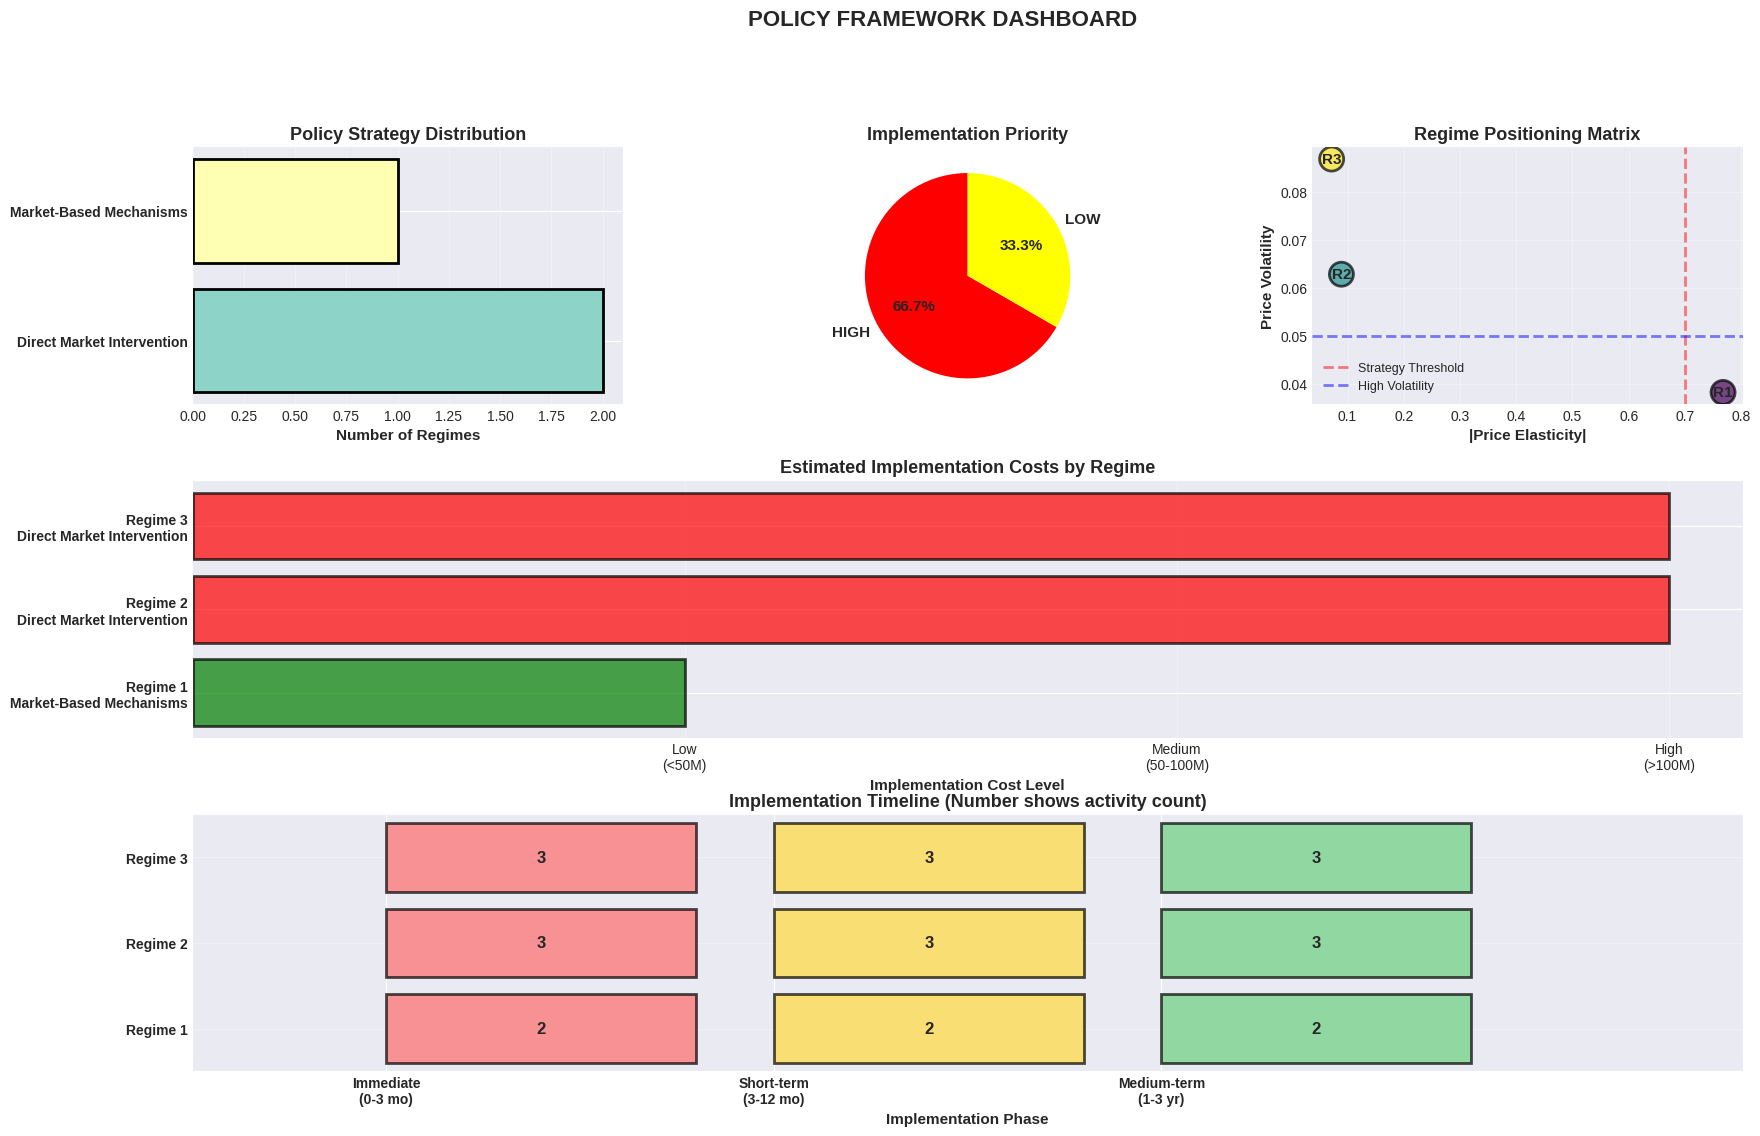

In [21]:
from matplotlib.patches import Rectangle

# Figure 1: Policy Framework Dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Policy Strategy Distribution
ax1 = fig.add_subplot(gs[0, 0])
strategies = policy_df['Primary_Strategy'].value_counts()
colors = plt.cm.Set3(range(len(strategies)))
ax1.barh(range(len(strategies)), strategies.values, color=colors, edgecolor='black', linewidth=2)
ax1.set_yticks(range(len(strategies)))
ax1.set_yticklabels(strategies.index, fontsize=10, fontweight='bold')
ax1.set_xlabel('Number of Regimes', fontsize=11, fontweight='bold')
ax1.set_title('Policy Strategy Distribution', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')

# 2. Priority Matrix
ax2 = fig.add_subplot(gs[0, 1])
priority_colors = {'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'yellow', 'VERY LOW': 'green'}
priorities = [p.split('(')[0].strip() for p in policy_df['Priority']]
priority_counts = pd.Series(priorities).value_counts()
ax2.pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%',
        colors=[priority_colors.get(p, 'gray') for p in priority_counts.index],
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Implementation Priority', fontsize=13, fontweight='bold')

# 3. Elasticity vs Volatility Positioning
ax3 = fig.add_subplot(gs[0, 2])
scatter = ax3.scatter(policy_df['Elasticity'].abs(), policy_df['Volatility'],
                     s=300, c=policy_df['Regime'], cmap='viridis',
                     alpha=0.7, edgecolors='black', linewidth=2)
for _, row in policy_df.iterrows():
    ax3.annotate(f"R{row['Regime']}",
                (abs(row['Elasticity']), row['Volatility']),
                fontsize=11, fontweight='bold', ha='center', va='center')
ax3.axvline(x=0.7, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Strategy Threshold')
ax3.axhline(y=0.05, color='blue', linestyle='--', alpha=0.5, linewidth=2, label='High Volatility')
ax3.set_xlabel('|Price Elasticity|', fontsize=11, fontweight='bold')
ax3.set_ylabel('Price Volatility', fontsize=11, fontweight='bold')
ax3.set_title('Regime Positioning Matrix', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 4. Intervention Cost Estimates
ax4 = fig.add_subplot(gs[1, :])
budget_map = {'High (>100M LKR annually)': 3, 'Medium (50-100M LKR annually)': 2, 'Low (<50M LKR annually)': 1}
budget_scores = [budget_map.get(impl['Budget'], 1) for impl in implementation_plan]
regimes = [impl['Regime'] for impl in implementation_plan]
strategies = [impl['Strategy'] for impl in implementation_plan]

bars = ax4.barh(range(len(regimes)), budget_scores,
               color=['red' if b==3 else 'orange' if b==2 else 'green' for b in budget_scores],
               alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_yticks(range(len(regimes)))
ax4.set_yticklabels([f"Regime {r}\n{s}" for r, s in zip(regimes, strategies)], fontsize=10, fontweight='bold')
ax4.set_xlabel('Implementation Cost Level', fontsize=11, fontweight='bold')
ax4.set_xticks([1, 2, 3])
ax4.set_xticklabels(['Low\n(<50M)', 'Medium\n(50-100M)', 'High\n(>100M)'], fontsize=10)
ax4.set_title('Estimated Implementation Costs by Regime', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3, axis='x')

# 5. Timeline Gantt Chart
ax5 = fig.add_subplot(gs[2, :])
phases = ['Immediate\n(0-3 mo)', 'Short-term\n(3-12 mo)', 'Medium-term\n(1-3 yr)']
phase_colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']

for idx, impl in enumerate(implementation_plan):
    for phase_idx, phase in enumerate(['Immediate (0-3 months)', 'Short-term (3-12 months)', 'Medium-term (1-3 years)']):
        if phase in impl['Timeline']:
            ax5.add_patch(Rectangle((phase_idx, idx-0.4), 0.8, 0.8,
                                   facecolor=phase_colors[phase_idx],
                                   edgecolor='black', linewidth=2, alpha=0.7))
            n_activities = len(impl['Timeline'][phase])
            ax5.text(phase_idx+0.4, idx, str(n_activities),
                    ha='center', va='center', fontsize=12, fontweight='bold')

ax5.set_xlim(-0.5, 3.5)
ax5.set_ylim(-0.5, len(implementation_plan)-0.5)
ax5.set_xticks(range(len(phases)))
ax5.set_xticklabels(phases, fontsize=10, fontweight='bold')
ax5.set_yticks(range(len(implementation_plan)))
ax5.set_yticklabels([f"Regime {impl['Regime']}" for impl in implementation_plan],
                    fontsize=10, fontweight='bold')
ax5.set_title('Implementation Timeline (Number shows activity count)',
             fontsize=13, fontweight='bold')
ax5.set_xlabel('Implementation Phase', fontsize=11, fontweight='bold')
ax5.grid(alpha=0.3, axis='y')

plt.suptitle('POLICY FRAMEWORK DASHBOARD', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('4_policy_framework_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

**19.REGIME-SPECIFIC POLICY RECOMMENDATIONS**

In [22]:
# Create comprehensive policy report
for policy in policy_framework:
    print(f"\n{'='*80}")
    print(f"REGIME {policy['Regime']}: {policy['Primary_Strategy'].upper()}")
    print(f"{'='*80}")
    print(f"\nMarket Characteristics:")
    print(f"  • Market Type: {policy['Market_Type']}")
    print(f"  • Price Elasticity: {policy['Elasticity']:.4f}")
    print(f"  • Average Price: LKR {policy['Avg_Price']:.2f}")
    print(f"  • Price Volatility: {policy['Volatility']:.4f}")
    print(f"  • Price Trend: {policy['Price_Trend']:.4f} ({'Rising' if policy['Price_Trend'] > 0 else 'Falling'})")
    print(f"\nImplementation Priority: {policy['Priority']}")
    print(f"\nRationale:")
    print(f"  {policy['Rationale']}")
    print(f"\nRecommended Interventions:")
    for i, intervention in enumerate(policy['Interventions'], 1):
        print(f"  {i}. {intervention}")


REGIME 1: MARKET-BASED MECHANISMS

Market Characteristics:
  • Market Type: Elastic
  • Price Elasticity: 0.7677
  • Average Price: LKR 48256.10
  • Price Volatility: 0.0382
  • Price Trend: -0.0013 (Falling)

Implementation Priority: LOW

Rationale:
  Market shows healthy price responsiveness. Focus on enabling efficient market operations.

Recommended Interventions:
  1. Market Information System (Price Transparency)
  2. Quality Certification & Grading Standards
  3. Promote Competitive Market Environment
  4. Support Value Chain Integration
  5. Light-Touch Regulatory Framework

REGIME 2: DIRECT MARKET INTERVENTION

Market Characteristics:
  • Market Type: Highly Inelastic
  • Price Elasticity: 0.0891
  • Average Price: LKR 48735.43
  • Price Volatility: 0.0628
  • Price Trend: -0.0321 (Falling)

Implementation Priority: HIGH (↑ due to high volatility)

Rationale:
  Market is highly unresponsive to price signals. Direct intervention needed to stabilize prices and ensure supply con